In [1]:
import requests

In [2]:
with open("./api-key", "r") as f:
    api_key = f.readline()

HEADER = {
  "Authorization": "Bearer " + api_key,
  "Accept": "application/vnd.api+json"
}
PLAYER_NAME = "DDALKISOUP_kakao"
PLATFORM = "kakao"

In [3]:
def get_player_match_list(player_name, platform, header):
    r = requests.get(
        url=f"https://api.pubg.com/shards/{platform}/players?filter[playerNames]={player_name}",
        headers=header
    )
    j = r.json()

    return j["data"][0]["relationships"]["matches"]["data"]

def get_match_data(match_id, platform):
    r = requests.get(
        url=f"https://api.pubg.com/shards/{platform}/matches/{match_id}",
        headers={"Accept": "application/vnd.api+json"}
    )
    return r.json()

def get_match_telemetry_events(match_id, platform)->list:
    match = get_match_data(match_id, platform)
    
    telemetry_events_id = match["data"]["relationships"]["assets"]["data"][0]["id"]
    telemetry_events_url = [x for x in match["included"] if x["type"] == "asset" and x["id"] == telemetry_events_id][0]["attributes"]["URL"]

    telemetry_events = requests.get(
        url=telemetry_events_url,
        headers={"Accept": "application/vnd.api+json"},
    )

    return telemetry_events.json()

In [4]:
te = get_match_telemetry_events("0560ca7b-7584-4076-8501-8141e50795c7", "kakao")
te

[{'MatchId': 'match.bro.official.pc-2018-18.kakao.squad.kakao.2022.08.05.11.0560ca7b-7584-4076-8501-8141e50795c7',
  'PingQuality': '',
  '_D': '2022-08-05T11:21:46.4483915Z',
  '_T': 'LogMatchDefinition'},
 {'accountId': 'account.7dbb2027c6fb4bbbbcf63a0a36f7d79a',
  'common': {'isGame': 0},
  '_D': '2022-08-05T11:19:35.973Z',
  '_T': 'LogPlayerLogin'},
 {'character': {'name': 'passat0982',
   'teamId': 1,
   'health': 100,
   'location': {'x': 305064.21875, 'y': 330952.5, 'z': 680.4173583984375},
   'ranking': 0,
   'accountId': 'account.7dbb2027c6fb4bbbbcf63a0a36f7d79a',
   'isInBlueZone': False,
   'isInRedZone': False,
   'zone': []},
  'item': {'itemId': 'Item_Weapon_Apple_C',
   'stackCount': 1,
   'category': 'Equipment',
   'subCategory': 'Throwable',
   'attachedItems': []},
  'common': {'isGame': 0},
  '_D': '2022-08-05T11:19:35.987Z',
  '_T': 'LogItemEquip'},
 {'character': {'name': 'passat0982',
   'teamId': 1,
   'health': 100,
   'location': {'x': 305064.21875, 'y': 33095

In [25]:
positions = [(e["character"]["location"]["x"], e["character"]["location"]["y"]) for e in te if e["_T"] == "LogPlayerPosition"]
len(positions)

7578

[PUBG API Github](https://github.com/pubg/api-documentation-content/blob/master/rst/telemetry-objects.rst)

### Location
```
{
  "x": number,
  "y": number,
  "z": number
}
```

* Location values are measured in centimeters.
* (0,0) is at the top-left of each map.
* The range for the X and Y axes is 0 - 816,000 for Erangel and Miramar.
* The range for the X and Y axes is 0 - 612,000 for Vikendi.
* The range for the X and Y axes is 0 - 408,000 for Sanhok.
* The range for the X and Y axes is 0 - 204,000 for Karakin and Range

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats.kde import gaussian_kde
from io import BytesIO
from PIL import Image

# import matplotlib.image as mpimg
# import seaborn as sns

In [15]:
map_image_urls = {
    "sanhok": "https://github.com/pubg/api-assets/blob/94195861e925168e9c51c4fe448ddd32a095d124/Assets/Maps/Sanhok_Main_No_Text_Low_Res.png?raw=true",
}

def get_map_image(map_name)->Image:
    r = requests.get(map_image_urls[map_name])
    img = Image.open(BytesIO(r.content))
    return img

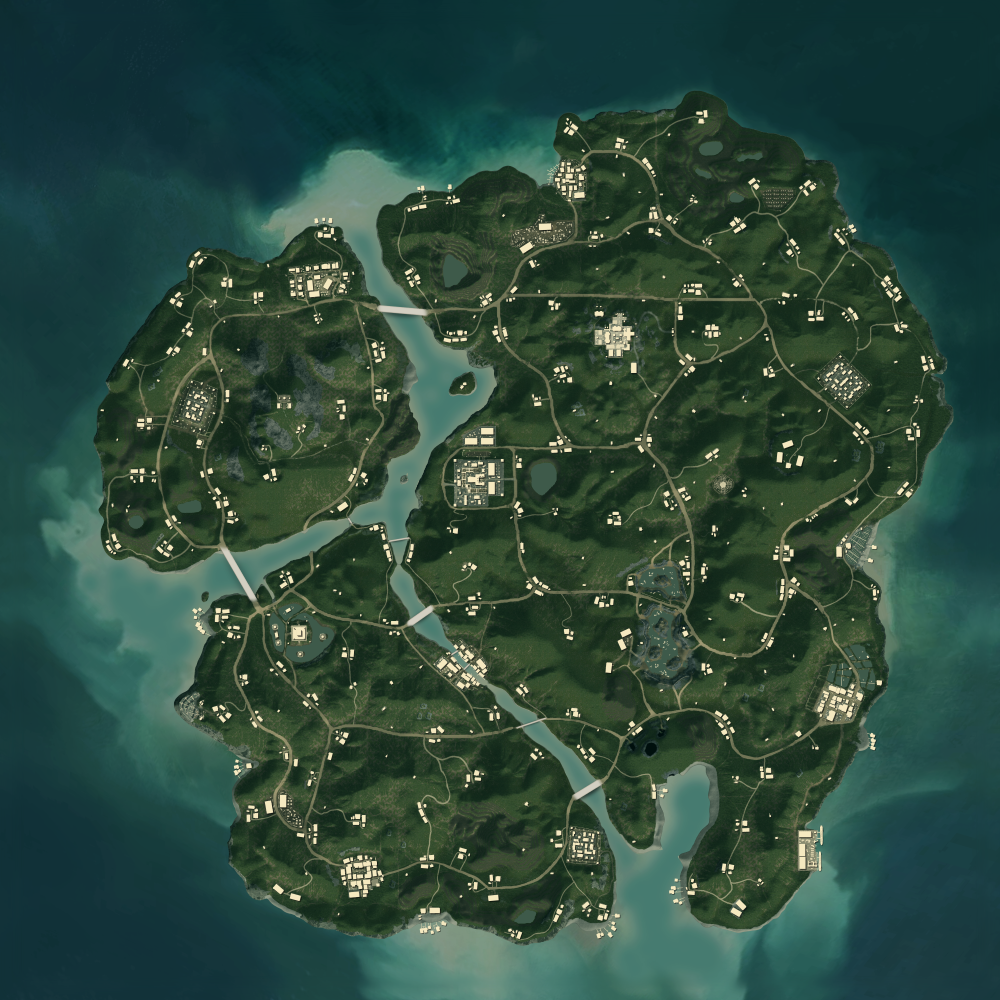

In [16]:
img_sanhok = get_map_image("sanhok")
img_sanhok

In [27]:
x = np.array([e[0] for e in positions])
y = np.array([e[1] for e in positions])

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j, y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

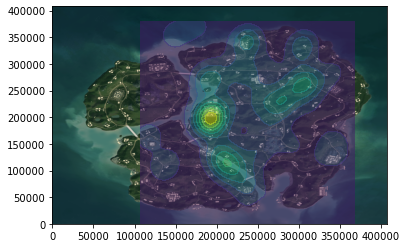

In [33]:
fig = plt.figure()
# ax1 = fig.add_subplot()
ax2 = fig.add_subplot()

# ax1.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.5)
ax2.contourf(xi, yi, zi.reshape(xi.shape), alpha=0.5)

# ax1.set_xlim(0, 408000)
# ax1.set_ylim(0, 408000)
ax2.set_xlim(0, 408000)
ax2.set_ylim(0, 408000)

# ax1.imshow(img_sanhok, extent=[0, 408000, 0, 408000], aspect='auto')
ax2.imshow(img_sanhok, extent=[0, 408000, 0, 408000], aspect='auto')